In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [4]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [6]:
df = df[~df['activity'].str.contains('Jogging|Sitting|Upstairs|Downstairs')]

In [7]:
print(df['activity'].value_counts())

Walking     424397
Standing     48395
Name: activity, dtype: int64


In [8]:
mapping = {'Walking': 0, 'Standing': 1}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

<ipython-input-8-cda07a43a212>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ActivityEncoded'] = df['activity'].map(mapping)


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
597,33,Walking,49394992294000,0.844462,8.008764,2.792171,0
598,33,Walking,49395102310000,1.116869,8.621680,3.786457,0
599,33,Walking,49395202316000,-0.503953,16.657684,1.307553,0
600,33,Walking,49395302292000,4.794363,10.760075,-1.184970,0
601,33,Walking,49395412338000,-0.040861,9.234595,-0.694638,0
...,...,...,...,...,...,...,...
1095664,19,Standing,131477821443000,-4.990000,8.390000,-0.380000,1
1095665,19,Standing,131477861513000,-5.130000,8.240000,-0.420000,1
1095666,19,Standing,131477941499000,-4.560000,8.500000,-0.890000,1
1095667,19,Standing,131477981508000,-4.480000,8.540000,-1.080000,1


In [9]:
df.shape

(472792, 7)

<ipython-input-10-2dec00f75b96>:2: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = "user_id", hue="activity", data = df, palette = [sns.color_palette()[0]],


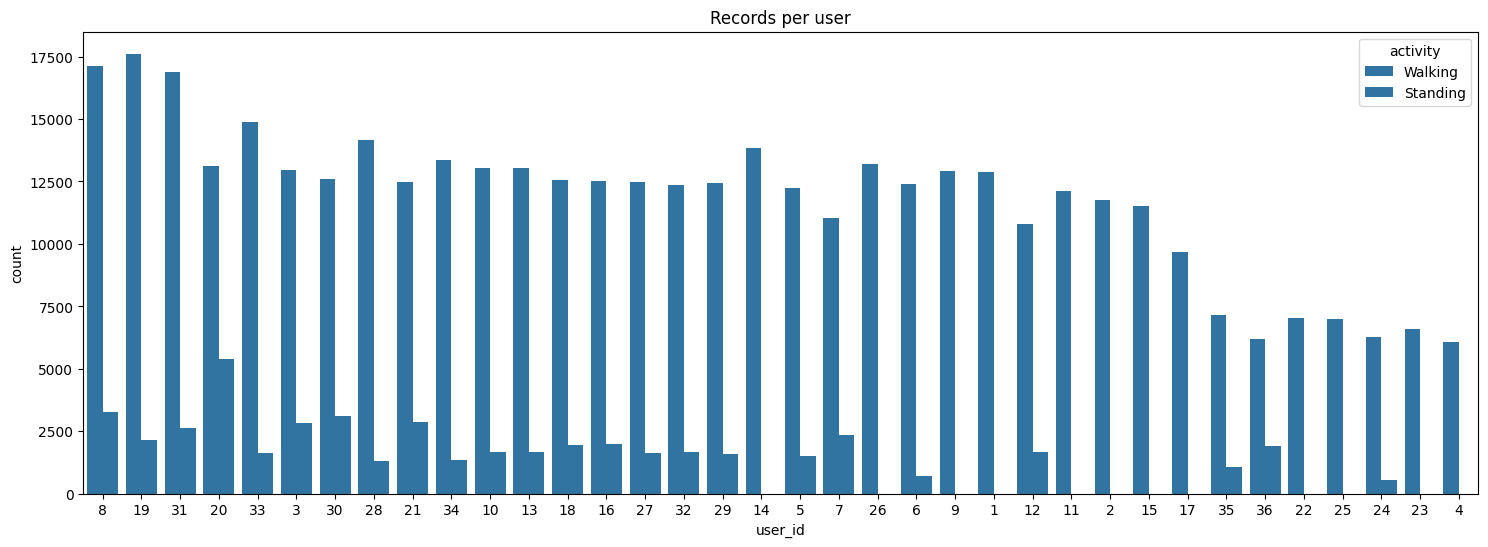

In [10]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

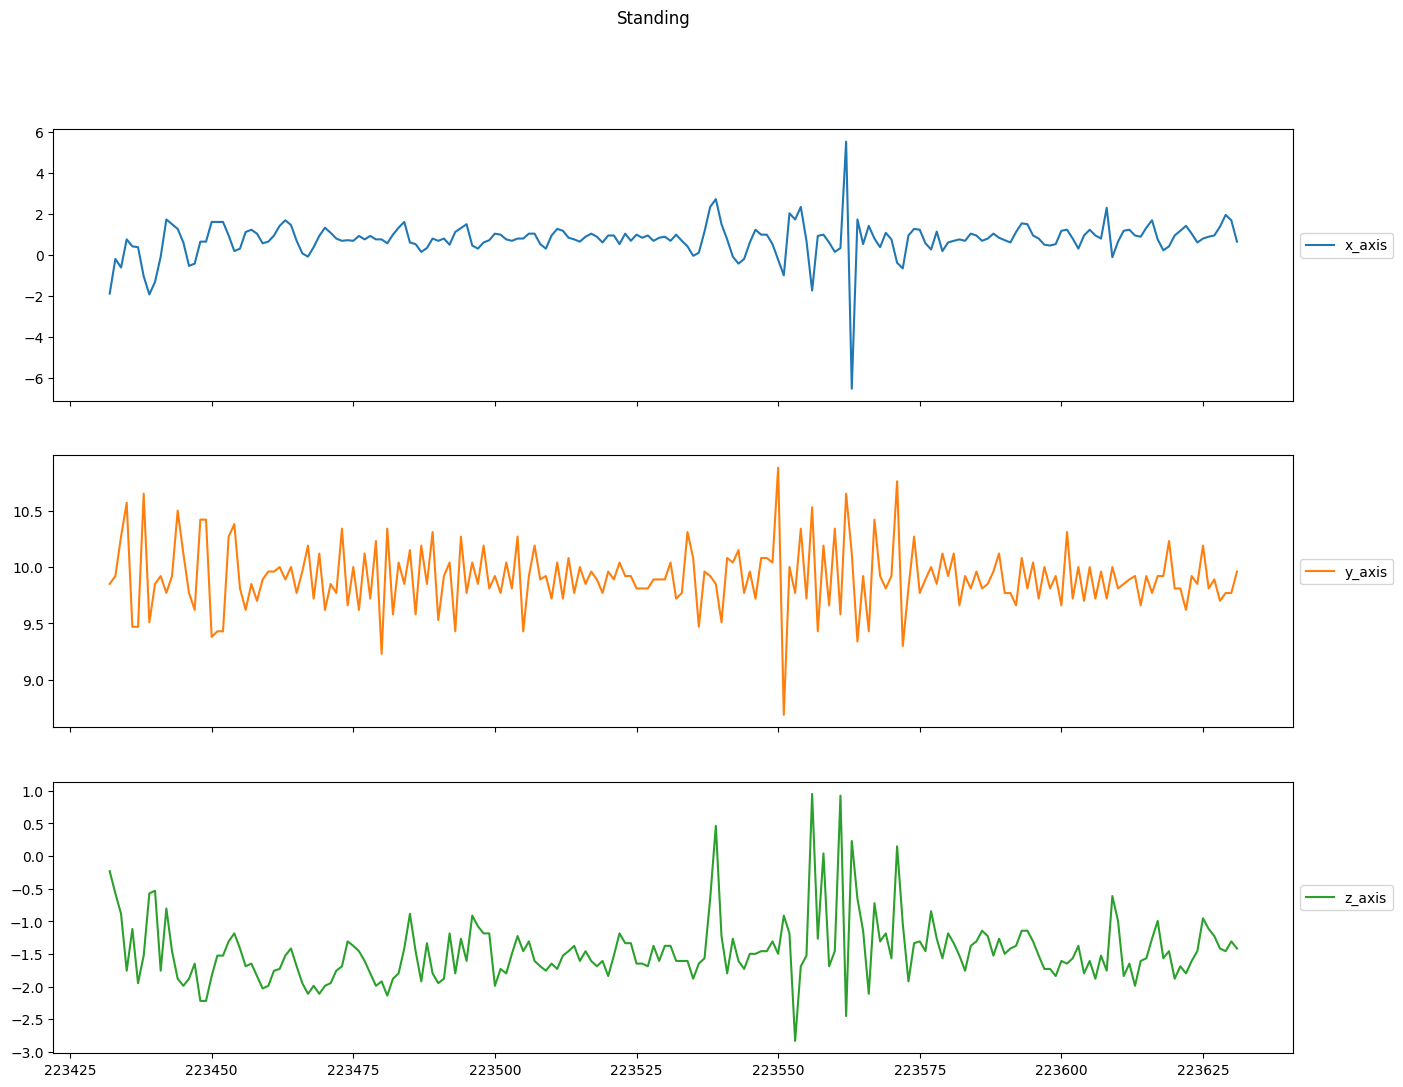

In [11]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7561, 200, 3) (7561, 1)
(2363, 200, 3) (2363, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(7561, 200, 3) (7561, 2) (2363, 200, 3) (2363, 2)


In [14]:
#Epoch 20

BATCH_SIZE = 128

verbose,epochs,batch_size=1,20, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

<h1>Epoch 10 (Data Balancing X)</h1>

In [15]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200, 100)          400       
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
60/60 [==============================] - 3s 15ms/step - loss: 0.9598 - accuracy: 0.8558 - val_loss: 0.2437 - val_accuracy: 0.9307
Epoch 2/10
60/60 [==============================] - 1s 11ms/step - loss: 0.2519 - accuracy: 0.9200 - val_loss: 0.3606 - val_accuracy: 0.8979
Epoch 3/10
60/60 [==============================] - 1s 10ms/step - loss: 0.1965 - accuracy: 0.9479 - val_loss: 0.2045 - val_accuracy: 0.9307
Epoch 4/10
60/60 [==============================] - 1s 13ms/step - loss: 0.1512 - accuracy: 0.9630 - val_loss: 0.1496 - val_accuracy: 0.9714
Epoch 5/10
60/60 [==============================] - 1s 13ms/step - loss: 0.1207 - accuracy: 0.9763 - val_loss: 0.1787 - val_accuracy: 0.9540
Epoch 6/10
60/60 [==============================] - 1s 11ms/step - loss: 0.1054 - accuracy: 0.9737 - val_loss: 0.1176 - val_accuracy: 0.9677
Epoch 7/10
60/60 [==============================] - 1s 10ms/step - loss: 0.0926 - accuracy: 0.9754 - val_loss: 0.0965 - val_accuracy: 0.9720
Epoch 8/10
60

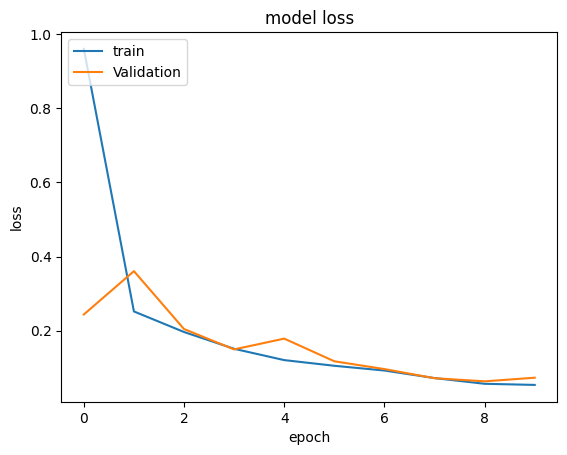

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

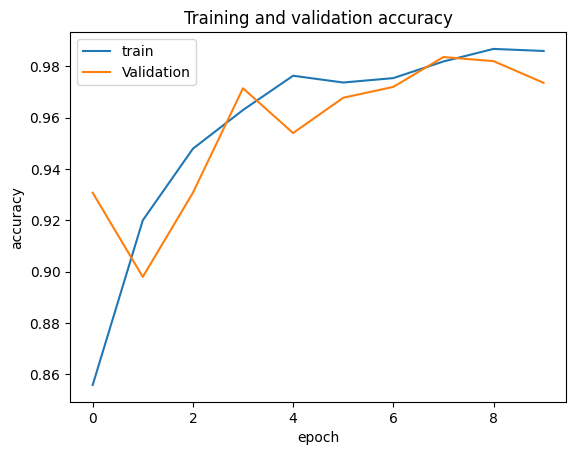

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

74/74 [==============================] - 1s 3ms/step
f1_score =  0.966611316588881
0.9691070672873466
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2122
           1       1.00      0.70      0.82       241

    accuracy                           0.97      2363
   macro avg       0.98      0.85      0.90      2363
weighted avg       0.97      0.97      0.97      2363



<Axes: >

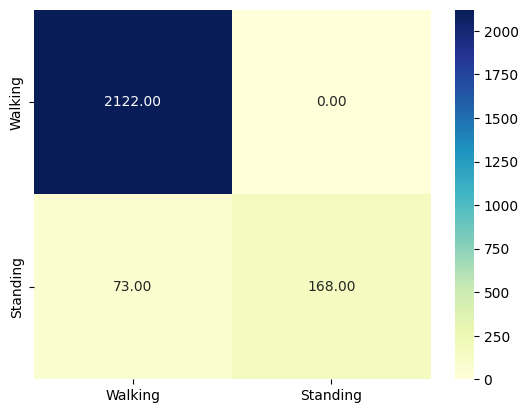

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Epoch 20 (Data Balancing X)</h1>

In [20]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200, 100)          400       
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/20
60/60 [==============================] - 1s 7ms/step - loss: 0.6185 - accuracy: 0.8840 - val_loss: 0.2475 - val_accuracy: 0.9265
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 0.2333 - accuracy: 0.9267 - val_loss: 0.2156 - val_accuracy: 0.9556
Epoch 3/20
60/60 [==============================] - 0s 4ms/step - loss: 0.2051 - accuracy: 0.9405 - val_loss: 0.2003 - val_accuracy: 0.9693
Epoch 4/20
60/60 [==============================] - 0s 4ms/step - loss: 0.1462 - accuracy: 0.9669 - val_loss: 0.1530 - val_accuracy: 0.9783
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.1190 - accuracy: 0.9712 - val_loss: 0.1639 - val_accuracy: 0.9614
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9745 - val_loss: 0.1271 - val_accuracy: 0.9683
Epoch 7/20
60/60 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9819 - val_loss: 0.0785 - val_accuracy: 0.9852
Epoch 8/20
60/60 [==

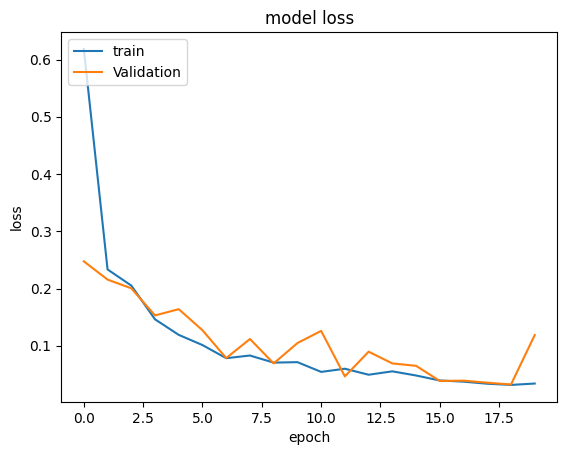

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

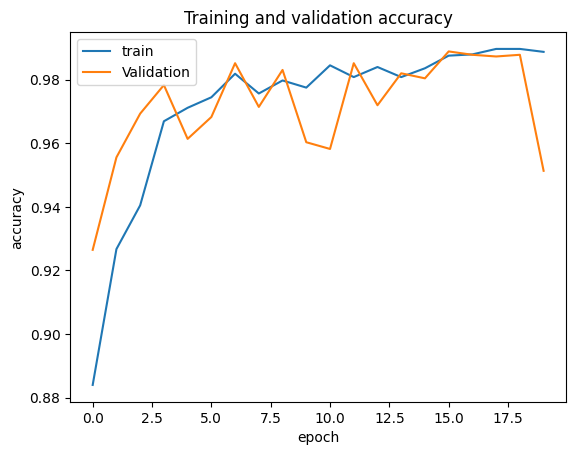

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

74/74 [==============================] - 1s 5ms/step
f1_score =  0.9539819640476038
0.9500634786288616
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2122
           1       0.68      0.98      0.80       241

    accuracy                           0.95      2363
   macro avg       0.84      0.96      0.89      2363
weighted avg       0.96      0.95      0.95      2363



<Axes: >

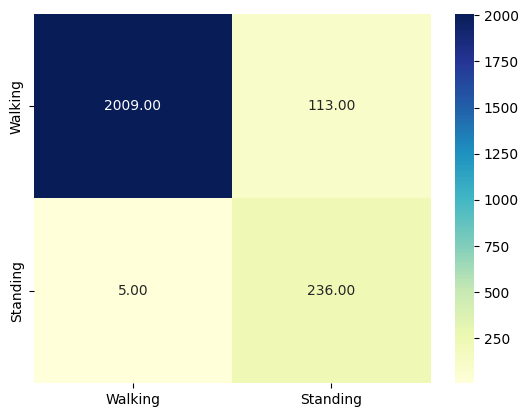

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Data Balacing</h1>

In [25]:
#Smote()를 통한 OverSampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('activity', axis=1), df['activity'])

In [26]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('activity', axis=1).columns),
                         pd.DataFrame({'activity': y_resampled})], axis=1)

In [27]:
print(df['activity'].value_counts())

Walking     424397
Standing    424397
Name: activity, dtype: int64


In [28]:
df.head()

,user_id,timestamp,x_axis,y_axis,z_axis,ActivityEncoded,activity
0,33,49394992294000,0.844462,8.008764,2.792171,0,Walking
1,33,49395102310000,1.116869,8.621680,3.786457,0,Walking
2,33,49395202316000,-0.503953,16.657684,1.307553,0,Walking
3,33,49395302292000,4.794363,10.760075,-1.184970,0,Walking
4,33,49395412338000,-0.040861,9.234595,-0.694638,0,Walking


In [29]:
df.shape

(848794, 7)

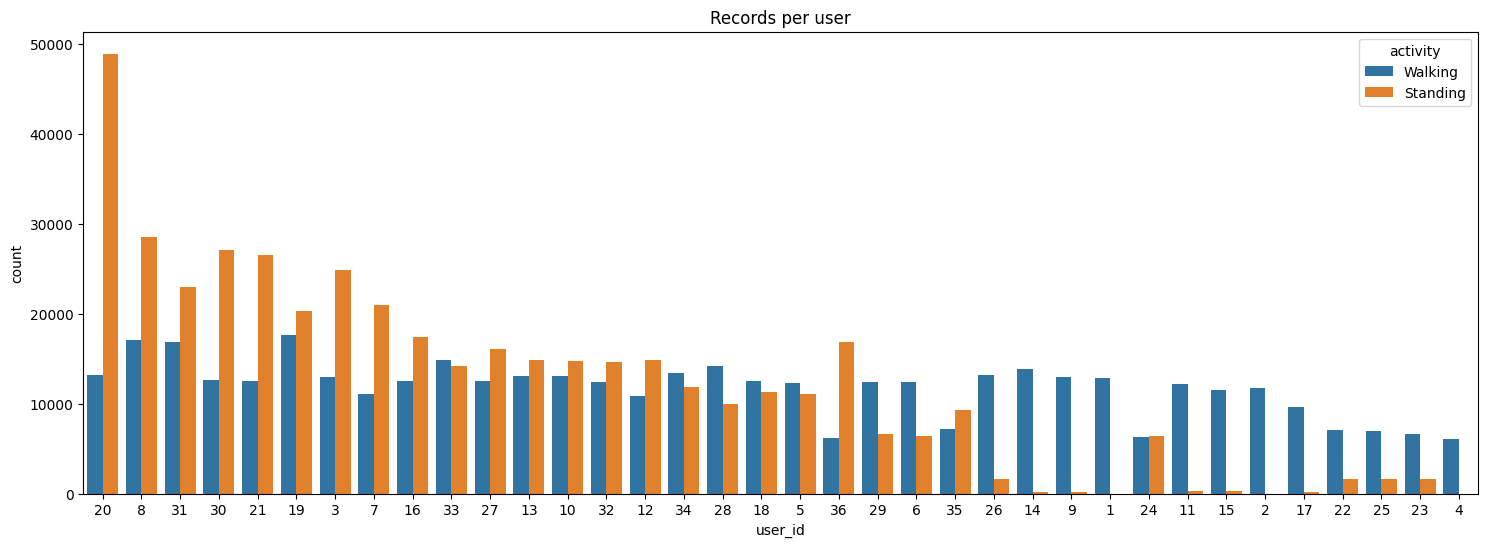

In [31]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

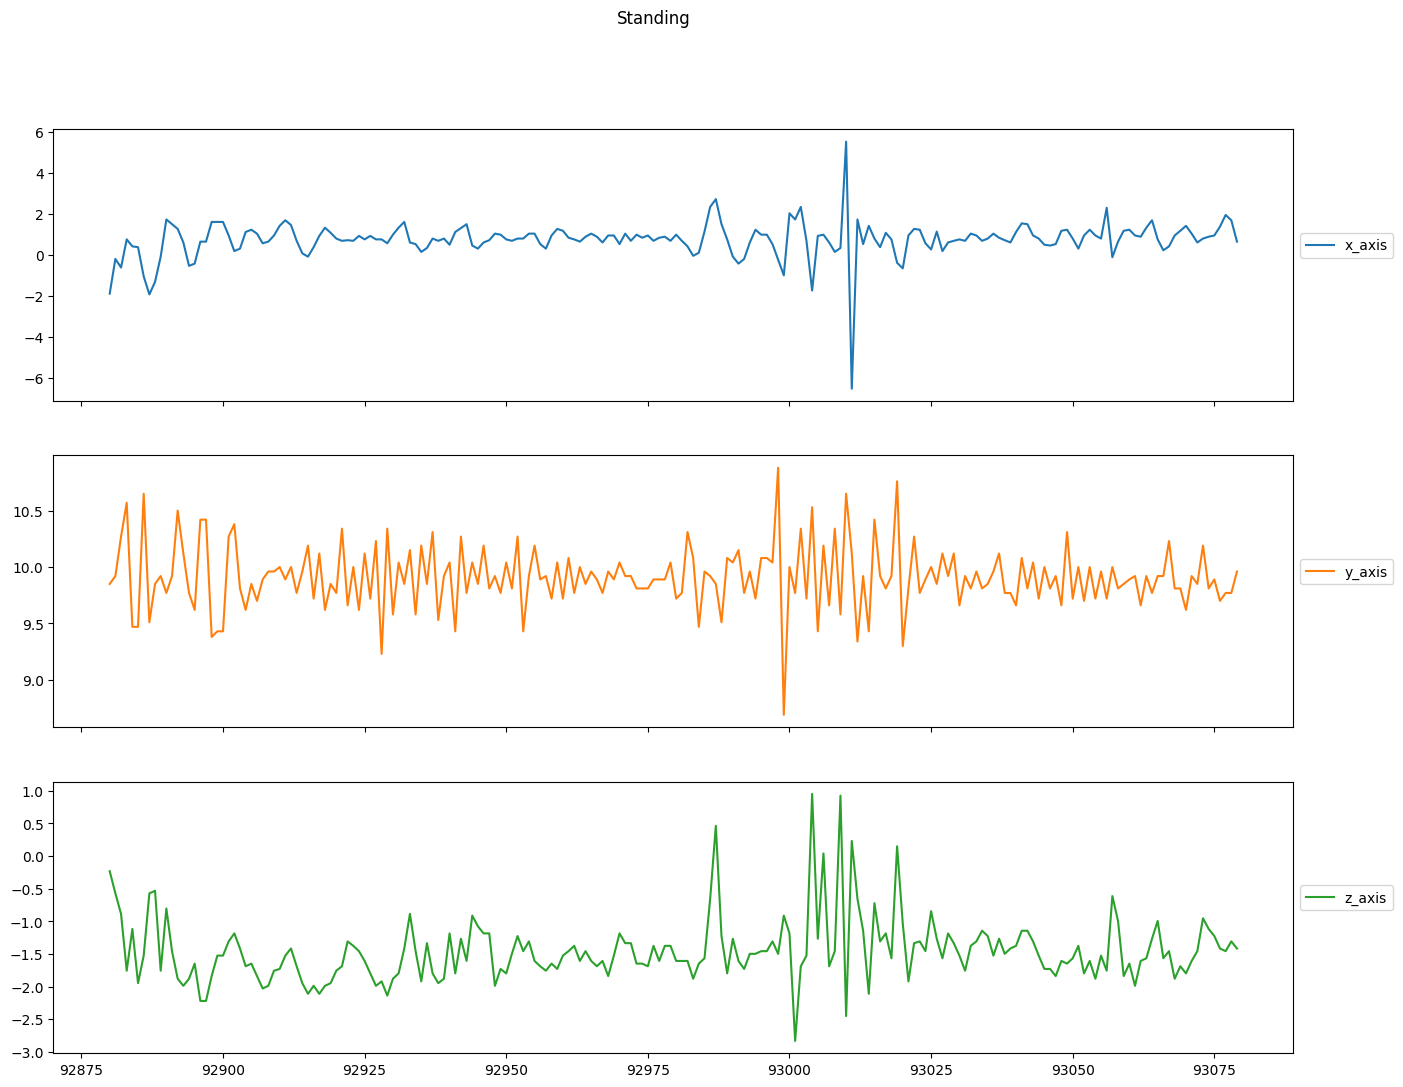

In [32]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [33]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13577, 200, 3) (13577, 1)
(4243, 200, 3) (4243, 1)


In [34]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(13577, 200, 3) (13577, 2) (4243, 200, 3) (4243, 2)


In [35]:
#Epoch 100

BATCH_SIZE = 128

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

<h1>Epoch 10 (Data Balancing O - OverSampling)</h1>

In [36]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200, 100)          400       
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
107/107 [==============================] - 2s 9ms/step - loss: 0.6076 - accuracy: 0.7918 - val_loss: 0.5066 - val_accuracy: 0.5938
Epoch 2/10
107/107 [==============================] - 1s 6ms/step - loss: 0.2336 - accuracy: 0.9269 - val_loss: 0.1443 - val_accuracy: 0.9782
Epoch 3/10
107/107 [==============================] - 1s 10ms/step - loss: 0.1384 - accuracy: 0.9669 - val_loss: 0.1103 - val_accuracy: 0.9535
Epoch 4/10
107/107 [==============================] - 1s 9ms/step - loss: 0.0827 - accuracy: 0.9856 - val_loss: 0.0666 - val_accuracy: 0.9859
Epoch 5/10
107/107 [==============================] - 1s 10ms/step - loss: 0.0600 - accuracy: 0.9896 - val_loss: 0.0571 - val_accuracy: 0.9909
Epoch 6/10
107/107 [==============================] - 1s 8ms/step - loss: 0.0475 - accuracy: 0.9916 - val_loss: 0.0843 - val_accuracy: 0.9723
Epoch 7/10
107/107 [==============================] - 1s 5ms/step - loss: 0.0396 - accuracy: 0.9919 - val_loss: 0.0557 - val_accuracy: 0.9909
Epoc

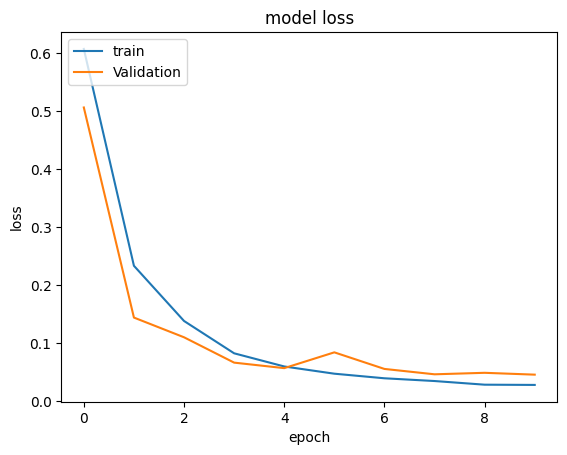

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

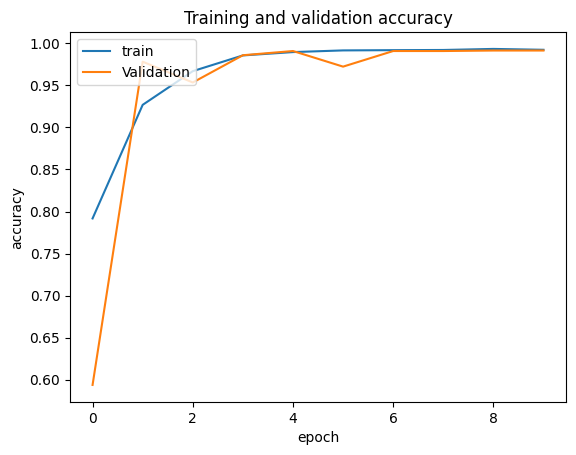

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

133/133 [==============================] - 1s 4ms/step
f1_score =  0.9938720559627691
0.9938722601932595
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2122
           1       1.00      0.99      0.99      2121

    accuracy                           0.99      4243
   macro avg       0.99      0.99      0.99      4243
weighted avg       0.99      0.99      0.99      4243



<Axes: >

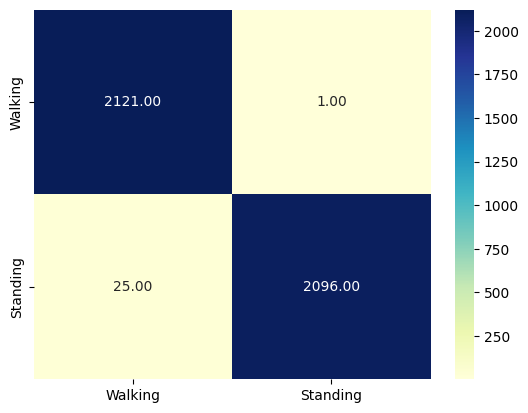

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Epoch 20 (Data Balancing O - OverSampling)</h1>

In [43]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200, 100)          400       
                                                                 
 flatten_4 (Flatten)         (None, 20000)             0         
                                                                 
 dense_9 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/20
107/107 [==============================] - 3s 19ms/step - loss: 1.0487 - accuracy: 0.7815 - val_loss: 0.3254 - val_accuracy: 0.8586
Epoch 2/20
107/107 [==============================] - 1s 6ms/step - loss: 0.2440 - accuracy: 0.9353 - val_loss: 0.1915 - val_accuracy: 0.9214
Epoch 3/20
107/107 [==============================] - 1s 7ms/step - loss: 0.1453 - accuracy: 0.9672 - val_loss: 0.1519 - val_accuracy: 0.9284
Epoch 4/20
107/107 [==============================] - 1s 5ms/step - loss: 0.0956 - accuracy: 0.9819 - val_loss: 0.0736 - val_accuracy: 0.9856
Epoch 5/20
107/107 [==============================] - 1s 5ms/step - loss: 0.0658 - accuracy: 0.9887 - val_loss: 0.0597 - val_accuracy: 0.9900
Epoch 6/20
107/107 [==============================] - 1s 5ms/step - loss: 0.0477 - accuracy: 0.9916 - val_loss: 0.0605 - val_accuracy: 0.9859
Epoch 7/20
107/107 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.9936 - val_loss: 0.0496 - val_accuracy: 0.9915
Epoch

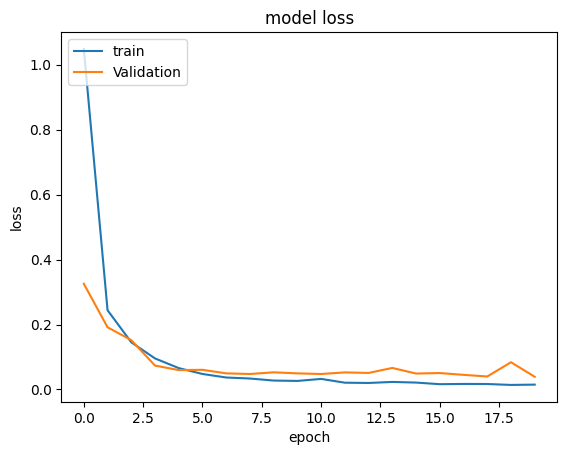

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

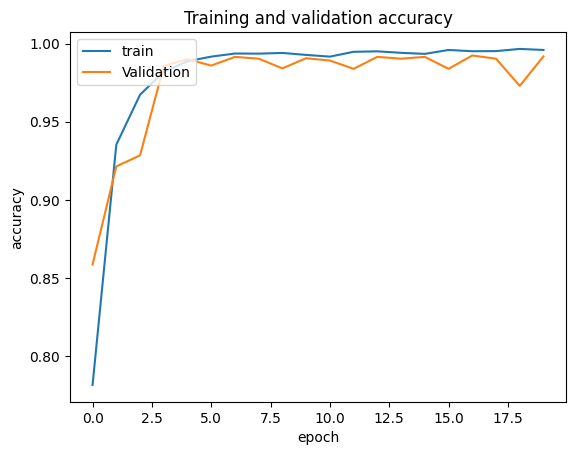

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

133/133 [==============================] - 0s 2ms/step
f1_score =  0.9948149772979543
0.9948149893942965
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2122
           1       1.00      0.99      0.99      2121

    accuracy                           0.99      4243
   macro avg       0.99      0.99      0.99      4243
weighted avg       0.99      0.99      0.99      4243



<Axes: >

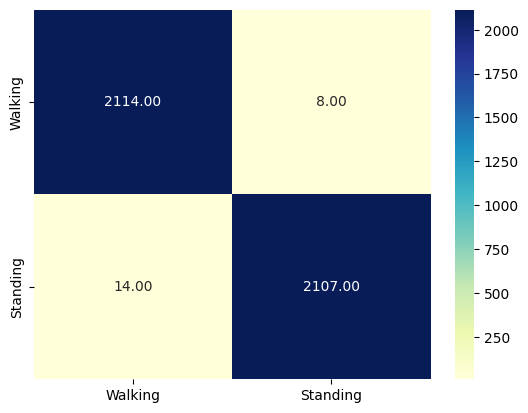

In [47]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')